# Laboratorio 7 - series de tiempo

### Ricardo Valenzuela
### Diego Solorzano

Cada uno de los conjuntos representan series de tiempo, pero muestran diferentes características relacionadas con la tendencias, estacionalidad, período, etc.

Hemos visto 5 métodos diferentes para predecir con series de tiempo, a decir:
 1. Promedio (para usar como base de referencia)
 2. SARIMAX
 3. Alisamiento exponencial (Winter-Holt)
 4. Red Neuronal
 5. FB Prophet

En este laboratorio, deben ejecutar los 5 métodos para cada uno de los conjuntos de datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statistics import *
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.pyplot import figure

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import fbprophet

Importing plotly failed. Interactive plots will not work.


In [2]:
def division_entreno_prueba(datos, n_prueba):
    return datos[: -n_prueba], datos[-n_prueba:] 

### Carga de datos

In [3]:
births = pd.read_csv("daily-total-female-births.csv", encoding='latin1')
shampoo = pd.read_csv("shampoo.csv", encoding='latin1')
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')
monthly = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')

# Series de tiempo para daily-total-female-births.csv

In [4]:
births.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [5]:
births.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [6]:
births.index = pd.to_datetime(births['Date'])
births.drop(columns='Date',inplace=True)
births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [7]:
train, prueba = division_entreno_prueba(births, 100)

In [8]:
train

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-09-18,53
1959-09-19,55
1959-09-20,39


In [9]:
prueba

,Births
Date,
1959-09-23,73
1959-09-24,55
1959-09-25,44
1959-09-26,43
1959-09-27,40
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


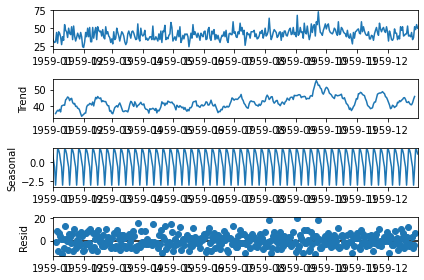

In [10]:
decompose_data = sm.tsa.seasonal_decompose(births, model="additive")
decompose_data.plot();

### Promedio
Obtenida de la presentacion

In [11]:
def prediccion_promedio(historia, config):
    n, tipo_prom = config
    if tipo_prom is "prom":
        return mean(historia[-n:])
    return median(historia[-n:])

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-11-34b0f1facfc2>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if tipo_prom is "prom":


In [12]:
print(prediccion_promedio(births['Births'], (265, 'prom')))

42.90188679245283


In [13]:
prueba["error"] = prueba["Births"] - prediccion_promedio(births['Births'], (265, 'prom'))

<ipython-input-13-820d69306867>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prueba["error"] = prueba["Births"] - prediccion_promedio(births['Births'], (265, 'prom'))


In [14]:
print("Error promedio: ", prueba.error.mean())

Error promedio:  1.5081132075471657


### Sarimax

In [15]:
train, prueba = division_entreno_prueba(births, 100)

<AxesSubplot:xlabel='Date'>

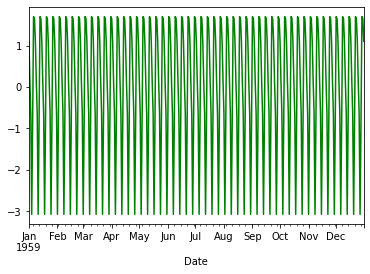

In [16]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

Hacemos esta prueba para ver si la Serie de Tiempo es estacionaria o no, vemos que el valor-p es muy cercano a 0 y menor que 0.05, lo que nos indica que es estacionaria y no hay que hacerle ningun procedimiento extra.

In [17]:
dftest = sm.tsa.stattools.adfuller(births.Births, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.808291253559764
2. P-Value :  5.2434129901498554e-05
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 358
5. Critical Values :
	 1% :  -3.448748905151901
	 5% :  -2.8696473721448728
	 10% :  -2.5710891239349585


In [18]:
model=sm.tsa.statespace.SARIMAX(train['Births'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Births   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -867.320
Date:                            Mon, 27 Sep 2021   AIC                           1744.640
Time:                                    03:27:53   BIC                           1762.287
Sample:                                01-01-1959   HQIC                          1751.741
                                     - 09-22-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0400      0.065      0.612      0.540      -0.088       0.168
ma.L1         -0.9669      0.030    -32.710      0.000      -1.025      -0.909
ar.S.L12      -0.1743      0.069     -2.514      0.012      -0.310      -0.038
ma.S.L12      -0.8919      0.072    -12.402      0.000      -1.033      -0.751
sigma2        51.2462      4.528     11.317      0.000      42.371      60.121
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.39
Prob(Q):                              0.97   Prob(JB):                         0.01
Heteroskedasticity (H):               0.88   Skew:                             0.16
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Vemos graficamente la prediccion.

<ipython-input-20-d1529d08e064>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['forecast']=results.predict(start=165,end=265,dynamic=True)


<AxesSubplot:xlabel='Date'>

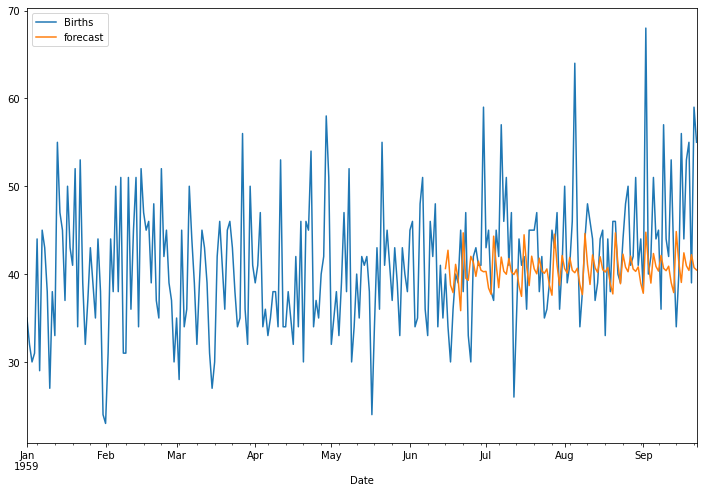

In [20]:
train['forecast']=results.predict(start=165,end=265,dynamic=True)
train[['Births','forecast']].plot(figsize=(12,8))

In [21]:
pred = results.predict(0, 100, dinamic= True, exog = prueba)[1:]
print("MSE: ",(mean_squared_error(prueba, pred)))
print("RMSE: ", sqrt(mean_squared_error(prueba, pred)))

MSE:  96.9960963541265
RMSE:  9.848659622208826


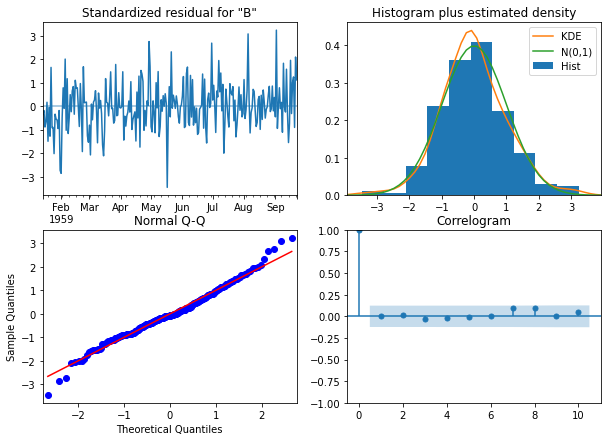

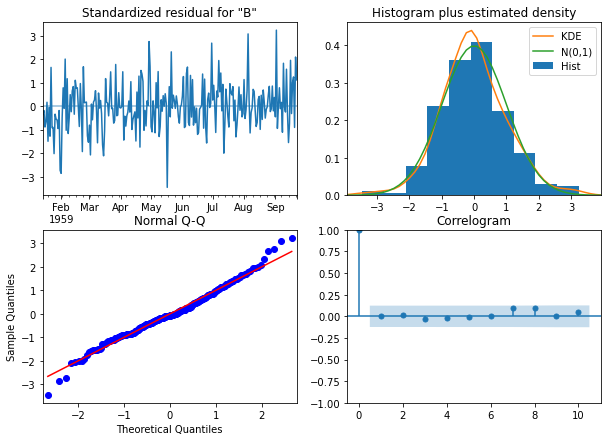

In [22]:
results.plot_diagnostics(figsize=(10, 7))

### Winter Holt

In [23]:
births2 = births

In [24]:
plt.rcParams['figure.figsize'] = [15, 7]

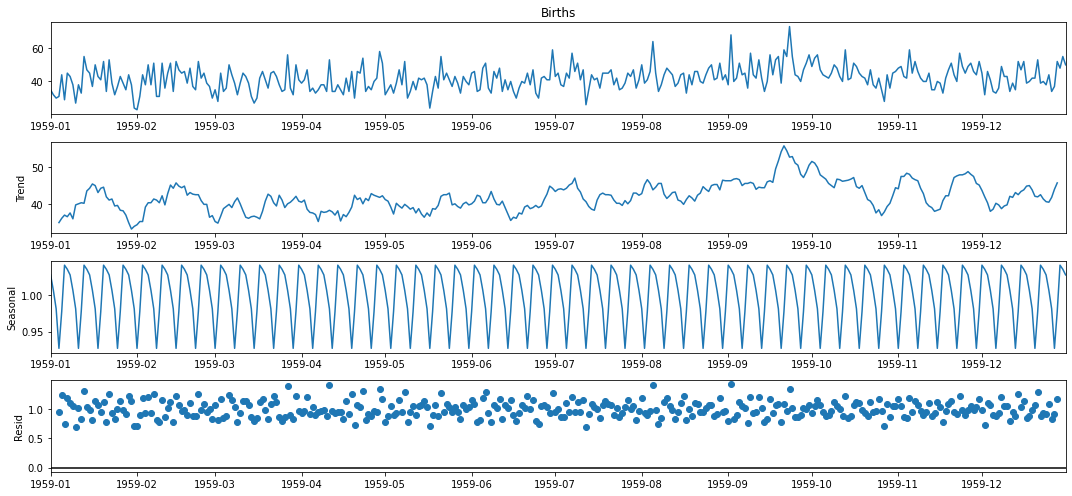

In [25]:
decompose_result = sm.tsa.seasonal_decompose(births2['Births'],model='multiplicative')
decompose_result.plot();

In [26]:
births.index.Births = 'MS'
m = 12
alpha = 1/(2*m)

C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


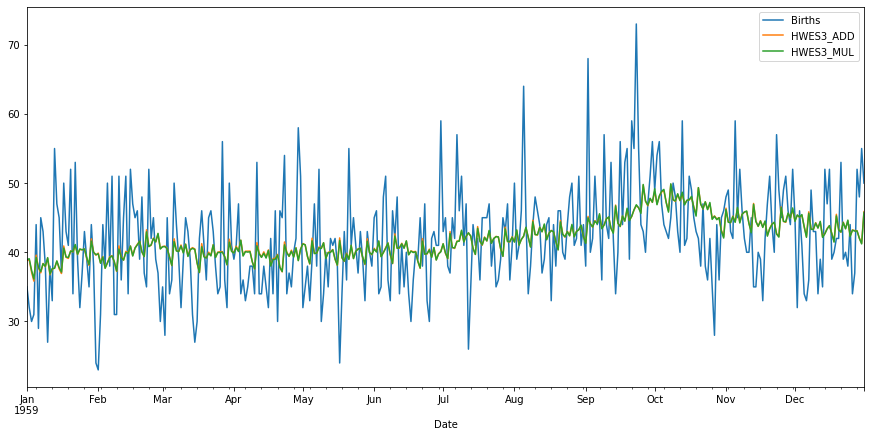

In [27]:
# Se usa triple HWES
births2['HWES3_ADD'] = ExponentialSmoothing(births2['Births'],trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
births2['HWES3_MUL'] = ExponentialSmoothing(births2['Births'],trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
births2[['Births','HWES3_ADD','HWES3_MUL']].plot();

In [28]:
train, prueba = division_entreno_prueba(births2, 150)

C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

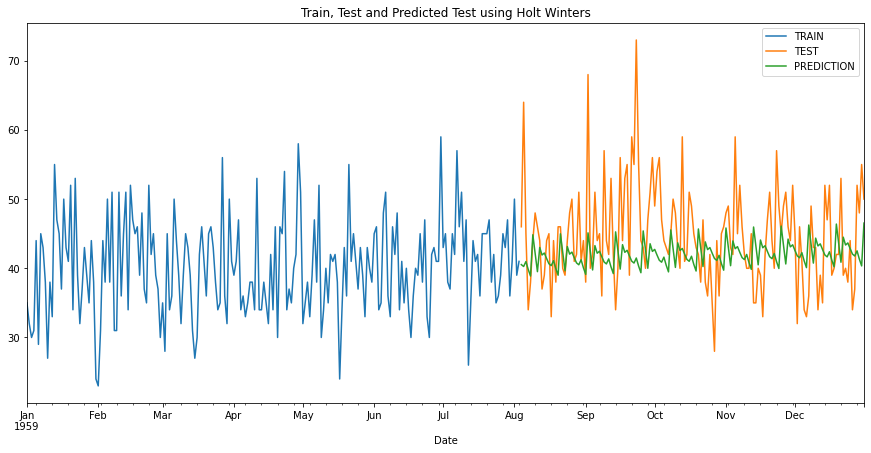

In [29]:
fitted_model = ExponentialSmoothing(train['Births'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(150)
train['Births'].plot(legend=True, label='TRAIN')
prueba['Births'].plot(legend=True, label='TEST', figsize=(15,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [30]:
print("MSE: ", mean_squared_error(prueba.Births,test_predictions))
print("RMSE: ",sqrt(mean_squared_error(prueba.Births,test_predictions)))

MSE:  62.40898341567212
RMSE:  7.899935658957744


### Redes Neuronales

In [31]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [32]:
np.random.seed(7)

In [33]:
births = pd.read_csv("daily-total-female-births.csv", encoding='latin1')

In [34]:
births.index = pd.to_datetime(births['Date'])
births.drop(columns='Date',inplace=True)
births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [35]:
train, prueba = division_entreno_prueba(births2, 150)

In [36]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
prueba = sc.fit_transform(prueba)

In [37]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(prueba, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [38]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Se comprueba el RMSE para el conjunto de prueba

In [ ]:
testScore = sqrt(mean_squared_error(testY, testPredict[:,0]))
print("MSE: ", mean_squared_error(testY, testPredict[:,0]))
print("RMSE: ", testScore)

### Prophet

In [ ]:
from pandas import to_datetime
births = pd.read_csv("daily-total-female-births.csv", encoding='latin1')

In [ ]:
births2 = births

In [ ]:
print('Prophet %s' % fbprophet.__version__)

In [ ]:
births2.columns = ['ds', 'y']
births2['ds']= to_datetime(births2['ds'])

In [ ]:
train, prueba = division_entreno_prueba(births2, 150)

In [ ]:
model = fbprophet.Prophet()
# fit the model
model.fit(train)

Prueba haciendo forecast a los datos de prueba

In [ ]:
future = list()
for i in range(8, 13):
    date = '1959-%01d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [ ]:
births.index = pd.to_datetime(births['ds'])
births.drop(columns='ds',inplace=True)
births.head()

In [ ]:
meses = births.resample('M').mean()
meses = meses[-5:]

In [ ]:
testScore = sqrt(mean_squared_error(meses, forecast["yhat"]))
print("RMSE: ", testScore)

# Series de tiempo para shampoo.csv

In [ ]:
shampoo = pd.read_csv("shampoo.csv", encoding='latin1')

In [ ]:
shampoo.info()

In [ ]:
shampoo.head()

In [ ]:
import datetime
shampoo['Month'] = shampoo['Month'].apply(lambda x: datetime.datetime.strptime(x, '%m-%d') if type(x)==str else np.NaN)

In [ ]:
shampoo.index = pd.to_datetime(shampoo['Month'])
shampoo.drop(columns='Month',inplace=True)
shampoo.head()

In [ ]:
train, prueba = division_entreno_prueba(shampoo, 12)

In [ ]:
decompose_data = sm.tsa.seasonal_decompose(shampoo.Sales,freq=10,model="additive")
fig = decompose_data.plot()
plt.show()

### Promedio

In [ ]:
print(prediccion_promedio(shampoo['Sales'], (24, 'prom')))

In [ ]:
prueba["error"] = prueba["Sales"] - prediccion_promedio(shampoo['Sales'], (24, 'prom'))

In [ ]:
print("Error promedio: ", prueba.error.mean())

### Sarimax

In [ ]:
train, prueba = division_entreno_prueba(shampoo, 12)

In [ ]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

En este caso el valor-p es uno mayo a 0.05, esto nos indica que no es estacionaria.

In [ ]:
dftest = sm.tsa.stattools.adfuller(shampoo.Sales, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

In [ ]:
results = sm.tsa.statespace.SARIMAX(shampoo, order=(1,1,1), seasonal_order=(0,0,0,32), exog = shampoo, enforce_invertibility=False).fit()
results.summary()

In [ ]:
train['forecast']=results.predict(start=14,end=24,dynamic=True)
train[['Sales','forecast']].plot(figsize=(12,8))

In [ ]:
pred = results.predict(0, 12, dinamic= True, exog = prueba)[1:]
print("MSE: ",(mean_squared_error(prueba, pred)))
print("RMSE: ", sqrt(mean_squared_error(prueba, pred)))

In [ ]:
results.plot_diagnostics(figsize=(10, 7))

### Winter Holt

In [ ]:
shampoo2 = shampoo

In [ ]:
plt.rcParams['figure.figsize'] = [15, 7]

In [ ]:
shampoo2.index.Sales = 'MS'
m = 12
alpha = 1/(2*m)

In [ ]:
# Se usa triple HWES se adapta bien
shampoo2['HWES3_ADD'] = ExponentialSmoothing(shampoo2['Sales'],trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
shampoo2['HWES3_MUL'] = ExponentialSmoothing(shampoo2['Sales'],trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
shampoo2[['Sales','HWES3_ADD','HWES3_MUL']].plot();

In [ ]:
train, prueba = division_entreno_prueba(shampoo, 12)

En la grafica no se observa adecuadamente pero se hicieron 12 forecast misteriosamente los etiqueta como del anio 1970.

In [ ]:
fitted_model = ExponentialSmoothing(train['Sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(12)
train['Sales'].plot(legend=True, label='TRAIN')
prueba['Sales'].plot(legend=True, label='TEST', figsize=(15,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [ ]:
print("MSE: ", mean_squared_error(prueba.Sales,test_predictions))
print("RMSE: ",sqrt(mean_squared_error(prueba.Sales,test_predictions)))

### Redes Neuronales

In [ ]:
np.random.seed(7)

In [ ]:
shampoo = pd.read_csv("shampoo.csv", encoding='latin1')

In [ ]:
shampoo['Month'] = shampoo['Month'].apply(lambda x: datetime.datetime.strptime(x, '%m-%d') if type(x)==str else np.NaN)
shampoo.index = pd.to_datetime(shampoo['Month'])
shampoo.drop(columns='Month',inplace=True)
shampoo.head()

In [ ]:
shampoo2 = shampoo

In [ ]:
train, prueba = division_entreno_prueba(shampoo2, 12)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
prueba = sc.fit_transform(prueba)

In [ ]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(prueba, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
testScore = sqrt(mean_squared_error(testY, testPredict[:,0]))
print("MSE: ", mean_squared_error(testY, testPredict[:,0]))
print("RMSE: ", testScore)

### Prophet

In [ ]:
shampoo = pd.read_csv("shampoo.csv", encoding='latin1')

In [ ]:
shampoo2 = shampoo

In [ ]:
import datetime
shampoo2['Month'] = shampoo2['Month'].apply(lambda x: datetime.datetime.strptime(x, '%m-%d') if type(x)==str else np.NaN)
shampoo2.columns = ['ds', 'y']
shampoo2['ds']= to_datetime(shampoo2['ds'])

In [ ]:
train, prueba = division_entreno_prueba(shampoo2, 12)

In [ ]:
model = fbprophet.Prophet()
# fit the model
model.fit(train)

La grafica muestra los meses 1 y 2, y muestra el forecast para el 3

In [ ]:
future = list()
for i in range(2, 5):
    date = '1900-%01d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [ ]:
shampoo.index = pd.to_datetime(shampoo['ds'])
shampoo.drop(columns='ds',inplace=True)
shampoo.head()

In [ ]:
meses = shampoo.resample('M').mean()
meses

In [ ]:
testScore = sqrt(mean_squared_error(meses, forecast["yhat"]))
print("MSE: ", mean_squared_error(meses, forecast["yhat"]))
print("RMSE: ", testScore)

# Series de tiempo para monthly-car-sales.csv

In [ ]:
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')

In [ ]:
cars.info()

In [ ]:
cars.head()

In [ ]:
cars.index = pd.to_datetime(cars['Month'])
cars.drop(columns='Month',inplace=True)
cars.head()

In [ ]:
train, prueba = division_entreno_prueba(cars, 25)

In [ ]:
decompose_data = sm.tsa.seasonal_decompose(cars, model="additive")
decompose_data.plot()

### Promedio

In [ ]:
print(prediccion_promedio(cars['Sales'], (85, 'prom')))

In [ ]:
prueba["error"] = prueba['Sales'] - prediccion_promedio(cars['Sales'], (85, 'prom'))

In [ ]:
print("Error promedio: ", prueba.error.mean())

### Sarimax

In [ ]:
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')
cars.index = pd.to_datetime(cars['Month'])
cars.drop(columns='Month',inplace=True)
cars.head()

In [ ]:
train, prueba = division_entreno_prueba(cars, 25)

In [ ]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

En este caso el valor-p es uno mayo a 0.05, esto nos indica que no es estacionaria.

In [ ]:
dftest = sm.tsa.stattools.adfuller(cars.Sales, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

In [ ]:
model=sm.tsa.statespace.SARIMAX(train['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

In [ ]:
results.summary()

In [ ]:
train['forecast']=results.predict(start=50,end=83,dynamic=True)
train[['Sales','forecast']].plot(figsize=(12,8))

In [ ]:
results.plot_diagnostics(figsize=(10, 7))

In [ ]:
pred = results.predict(58, 83, dinamic= True, exog = prueba)[1:]
print("MSE: ",(mean_squared_error(prueba, pred)))
print("RMSE: ", sqrt(mean_squared_error(prueba, pred)))

### Winter Holt

In [ ]:
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')
cars.index = pd.to_datetime(cars['Month'])
cars.drop(columns='Month',inplace=True)
cars.head()

In [ ]:
cars2 = cars

In [ ]:
plt.rcParams['figure.figsize'] = [15, 7]

In [ ]:
cars2.index.Sales = 'MS'
m = 12
alpha = 1/(2*m)

In [ ]:
# Se usa triple HWES
cars2['HWES3_ADD'] = ExponentialSmoothing(cars2['Sales'],trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
cars2['HWES3_MUL'] = ExponentialSmoothing(cars2['Sales'],trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
cars2[['Sales','HWES3_ADD','HWES3_MUL']].plot();

In [ ]:
train, prueba = division_entreno_prueba(cars2, 25)

In [ ]:
fitted_model = ExponentialSmoothing(train['Sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(25)
train['Sales'].plot(legend=True, label='TRAIN')
prueba['Sales'].plot(legend=True, label='TEST', figsize=(15,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [ ]:
print("MSE: ", mean_squared_error(prueba.Sales,test_predictions))
print("RMSE: ",sqrt(mean_squared_error(prueba.Sales,test_predictions)))

### Redes Nauronales

In [ ]:
np.random.seed(7)

In [ ]:
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')
cars.index = pd.to_datetime(cars['Month'])
cars.drop(columns='Month',inplace=True)
cars.head()

In [ ]:
train, prueba = division_entreno_prueba(cars, 25)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
prueba = sc.fit_transform(prueba)

In [ ]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(prueba, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
testScore = sqrt(mean_squared_error(testY, testPredict[:,0]))
print("MSE: ", mean_squared_error(testY, testPredict[:,0]))
print("RMSE: ", testScore)

### Prophet

In [ ]:
from pandas import to_datetime
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')

In [ ]:
cars2 = cars

In [ ]:
cars2.columns = ['ds', 'y']
cars2['ds']= to_datetime(cars2['ds'])

In [ ]:
train, prueba = division_entreno_prueba(cars2, 25)

In [ ]:
model = fbprophet.Prophet()
# fit the model
model.fit(train)

In [ ]:
train

In [ ]:
prueba

In [ ]:
future = list()
for i in range(1, 13):
    date = '1967-%1d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [ ]:
cars.index = pd.to_datetime(cars['ds'])
cars.drop(columns='ds',inplace=True)
cars.head()

In [ ]:
to_compare = cars[-24:]
to_compare = to_compare[:-12]
to_compare

In [ ]:
testScore = sqrt(mean_squared_error(to_compare, forecast["yhat"]))
print("MSE: ", mean_squared_error(to_compare, forecast["yhat"]))
print("RMSE: ", testScore)

# Series de tiempo para monthly-mean-temp.csv

In [76]:
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')

In [77]:
mmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        240 non-null    object 
 1   Temperature  240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [78]:
mmt.head()

,Month,Temperature
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [79]:
mmt.index = pd.to_datetime(mmt['Month'])
mmt.drop(columns='Month',inplace=True)
mmt.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [80]:
train, prueba = division_entreno_prueba(mmt, 70)

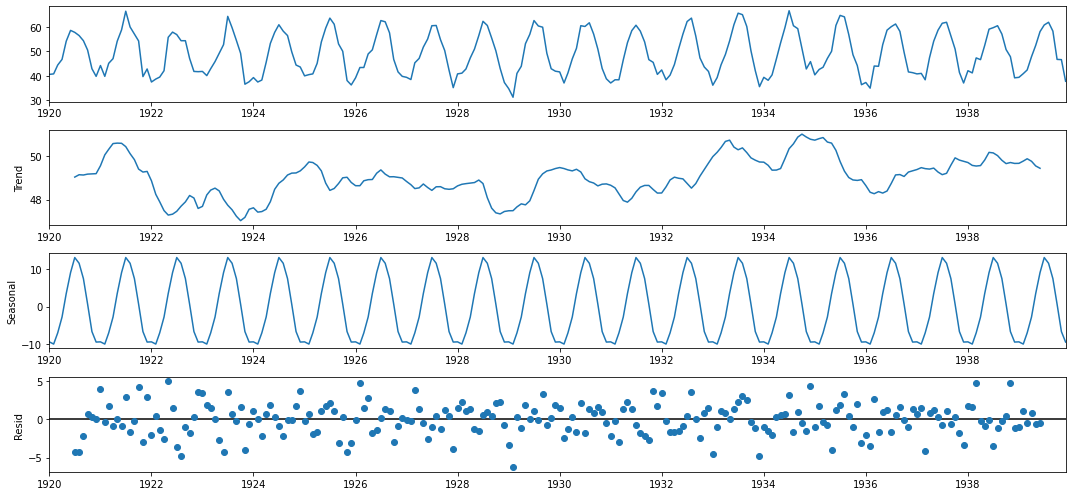

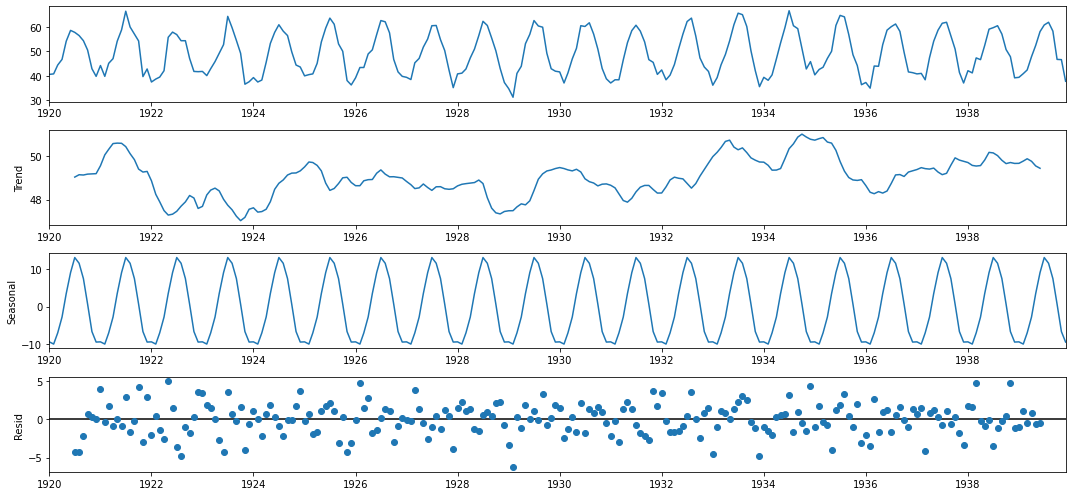

In [81]:
decompose_data = sm.tsa.seasonal_decompose(mmt, model="additive")
decompose_data.plot()

### Promedio

In [82]:
print(prediccion_promedio(mmt['Temperature'], (170, 'prom')))

49.06588235294117


In [83]:
prueba["error"] = prueba['Temperature'] - prediccion_promedio(mmt['Temperature'], (170, 'prom'))

<ipython-input-83-305aee2f6ef2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prueba["error"] = prueba['Temperature'] - prediccion_promedio(mmt['Temperature'], (170, 'prom'))


In [84]:
print("Error promedio: ", prueba.error.mean())

Error promedio:  0.8384033613445404


### Sarimax

In [50]:
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')
mmt.index = pd.to_datetime(mmt['Month'])
mmt.drop(columns='Month',inplace=True)
mmt.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [51]:
train, prueba = division_entreno_prueba(mmt, 70)

<AxesSubplot:xlabel='Month'>

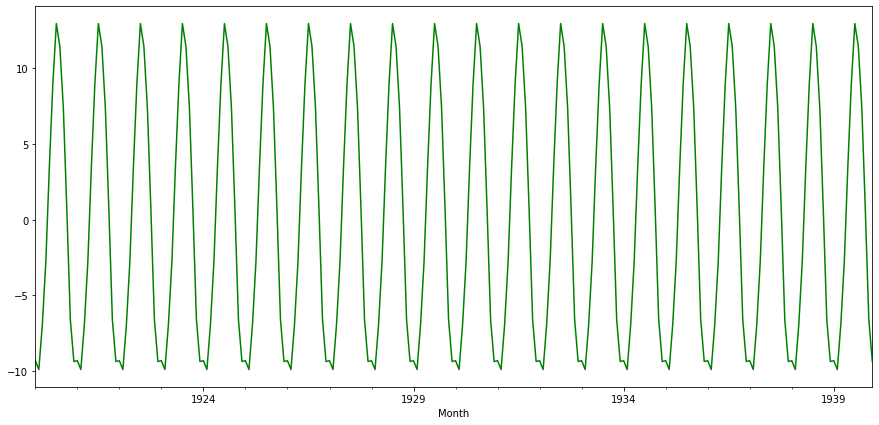

In [52]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

En este caso el valor-p es uno mayo a 0.05, esto nos indica que no es estacionaria.

In [53]:
dftest = sm.tsa.stattools.adfuller(mmt.Temperature, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.2554924030863264
2. P-Value :  0.016989030222609128
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 225
5. Critical Values :
	 1% :  -3.4597521044060353
	 5% :  -2.874472927517147
	 10% :  -2.5736628197530864


In [54]:
model=sm.tsa.statespace.SARIMAX(train['Temperature'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [55]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                  170
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -363.718
Date:                            Mon, 27 Sep 2021   AIC                            737.435
Time:                                    03:42:07   BIC                            752.717
Sample:                                01-01-1920   HQIC                           743.642
                                     - 02-01-1934                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3330      0.090      3.717      0.000       0.157       0.509
ma.L1         -0.9736      0.043    -22.412      0.000      -1.059      -0.888
ar.S.L12      -0.3536      0.100     -3.539      0.000      -0.549      -0.158
ma.S.L12      -0.6400      0.100     -6.370      0.000      -0.837      -0.443
sigma2         5.4107      0.671      8.062      0.000       4.095       6.726
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.82   Prob(JB):                         0.41
Heteroskedasticity (H):               0.91   Skew:                            -0.26
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<ipython-input-56-0a00e87f0656>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['forecast']=results.predict(start=100,end=170,dynamic=True)


<AxesSubplot:xlabel='Month'>

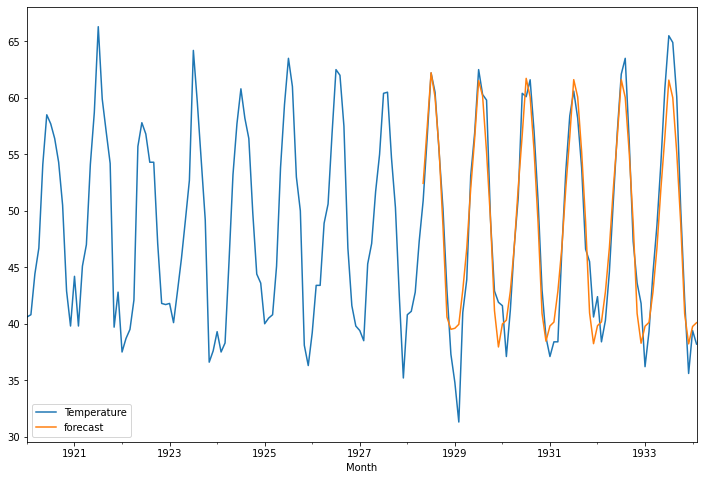

In [56]:
train['forecast']=results.predict(start=100,end=170,dynamic=True)
train[['Temperature','forecast']].plot(figsize=(12,8))

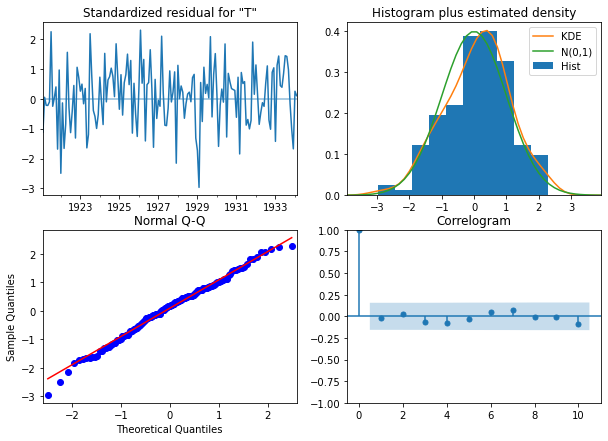

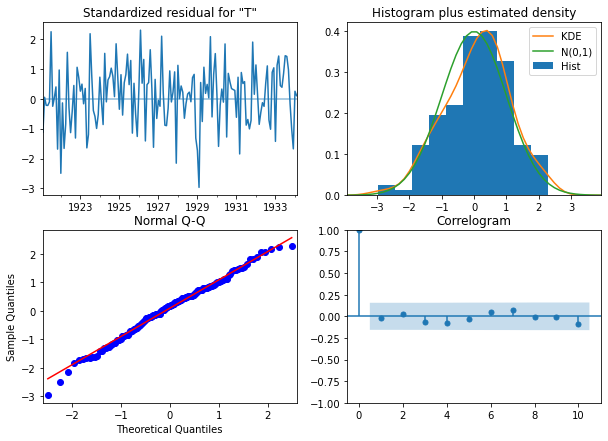

In [57]:
results.plot_diagnostics(figsize=(10, 7))

In [58]:
pred = results.predict(0, 70, dinamic= True, exog = prueba)[1:]
print("MSE: ",(mean_squared_error(prueba, pred)))
print("RMSE: ", sqrt(mean_squared_error(prueba, pred)))

MSE:  36.28088846202485
RMSE:  6.023361890342041


### Winter Holt

In [59]:
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')
mmt.index = pd.to_datetime(mmt['Month'])
mmt.drop(columns='Month',inplace=True)
mmt.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [60]:
mmt2 = mmt

In [61]:
plt.rcParams['figure.figsize'] = [15, 7]

In [62]:
mmt2.index.Temperature = 'MS'
m = 12
alpha = 1/(2*m)

C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


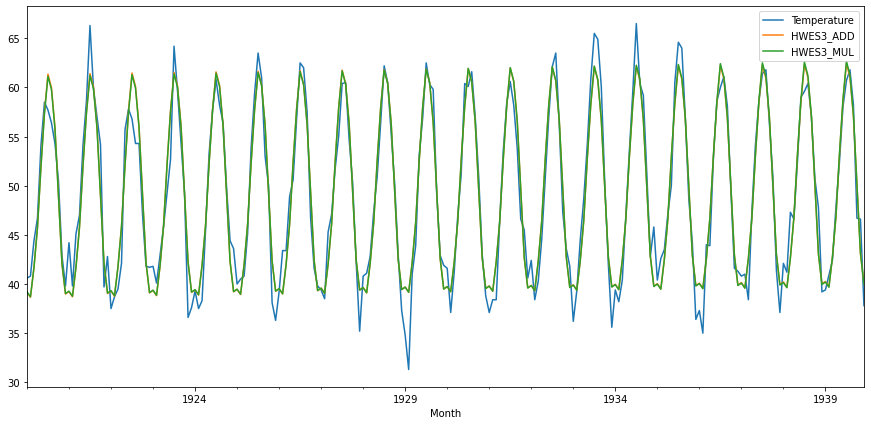

In [63]:
# Se usa triple HWES
mmt2['HWES3_ADD'] = ExponentialSmoothing(mmt2['Temperature'],trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
mmt2['HWES3_MUL'] = ExponentialSmoothing(mmt2['Temperature'],trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
mmt2[['Temperature','HWES3_ADD','HWES3_MUL']].plot();

In [64]:
train, prueba = division_entreno_prueba(mmt2, 70)

C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jdieg\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

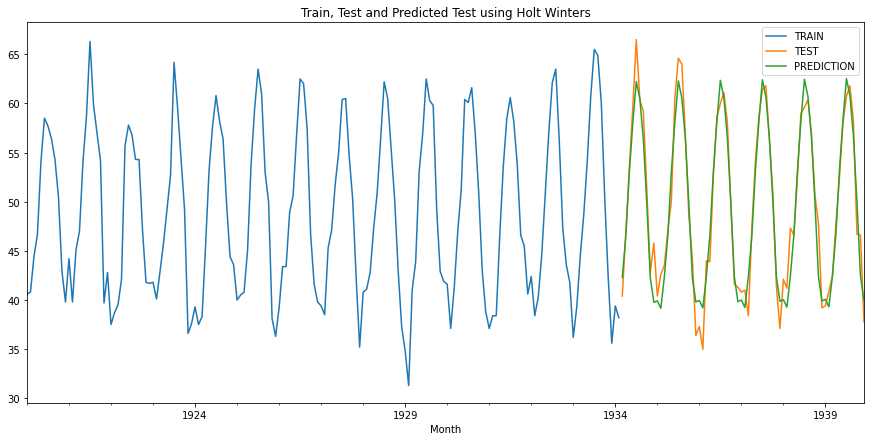

In [65]:
fitted_model = ExponentialSmoothing(train['Temperature'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(70)
train['Temperature'].plot(legend=True, label='TRAIN')
prueba['Temperature'].plot(legend=True, label='TEST', figsize=(15,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [66]:
print("MSE: ", mean_squared_error(prueba.Temperature,test_predictions))
print("RMSE: ",sqrt(mean_squared_error(prueba.Temperature,test_predictions)))

MSE:  4.701821187566537
RMSE:  2.168368323778628


### Redes Nauronales

In [67]:
np.random.seed(7)

In [68]:
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')
mmt.index = pd.to_datetime(mmt['Month'])
mmt.drop(columns='Month',inplace=True)
mmt.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [69]:
train, prueba = division_entreno_prueba(mmt, 70)

In [70]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
prueba = sc.fit_transform(prueba)

In [71]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(prueba, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [72]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [73]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [74]:
testScore = sqrt(mean_squared_error(testY, testPredict[:,0]))
print("MSE: ", mean_squared_error(testY, testPredict[:,0]))
print("RMSE: ", testScore)

MSE:  0.15256755120325463
RMSE:  0.3905989646725329


### Prophet

In [39]:
from pandas import to_datetime
mmt = pd.read_csv("monthly-car-Temperature.csv", encoding='latin1')

In [40]:
mmt2 = mmt

In [41]:
mmt2.columns = ['ds', 'y']
mmt2['ds']= to_datetime(mmt2['ds'])

In [ ]:
train, prueba = division_entreno_prueba(mmt2, 70)

In [ ]:
model = fbprophet.Prophet()
# fit the model
model.fit(train)

In [ ]:
train

In [ ]:
prueba

In [ ]:
future = list()
for i in range(1, 13):
    date = '1920-%1d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [ ]:
mmt.index = pd.to_datetime(mmt['ds'])
mmt.drop(columns='ds',inplace=True)
mmt.head()

In [ ]:
to_compare = mmt[-24:]
to_compare = to_compare[:-12]
to_compare

In [ ]:
testScore = sqrt(mean_squared_error(to_compare, forecast["yhat"]))
print("MSE: ", mean_squared_error(to_compare, forecast["yhat"]))
print("RMSE: ", testScore)

### ¿Qué métodos logran captar mejor las tendencias y las variaciones estacionales?
Al observar las descompocisiones de los data sets y las graficas generadas para cada metodo, se evidencia que los metodos Winter-Holt, SARIMA y Prophet logran captar y predecir bien las tendencias y variaciones estacionales de la data. Sin embargo, las redes neuronales obtenian un valor de error significativamente mas bajo.

### Generen una tabla comparativa que muestre los RMSE más bajos para cada método con cada conjunto de datos

In [88]:
rmse = pd.read_csv("tablaRMSE.csv", encoding='latin1')
rmse

,Unnamed: 0,Ninguna tendencia,Tendencia,Estacionalidad,Tendencia y Estacionalidad
0,Metodo/Datos,Nacimiento,Shampoo,Temperatura,Carros
1,Promedio,1.51,107.88,0.84,1620.29
2,SARIMA,9.85,312.03,6.02,1823.09
3,Holt-Winter,7.79,165.96,2.17,3108.64
4,Red Neuronal,0.19 (Ganador),0.28 (Ganador),NaN,0.23 (Ganador)


### Ahora apliquen el FB Prophet con cada uno de los conjuntos de datos. Compare los resultados con los de los métodos anteriores.  ¿Hay algún ganador claro, entre todos los métodos?
Para los datasets de nacimiento, shampoo, temperatura y carros, FB Prophet obtuvo RMSE de 3.65, 69.56, FALTA TEMP y 2895.32 respectivamente. A pesar de no ser el ganador en cada set, Prophet demuestra obtener un RMSE bajo consistentemente y no muestra una diferencia significativa del ganador.

### Escriban sus conclusiones sobre lo aprendido en este módulo sobre series de tiempo.  ¿Cuál es el mejor procedimiento para resolver un problema de predicción de series de tiempo?
- Hay una gran cantidad de metodos para series de tiempo y algunos demuestran ser mas eficientes que otros dependiendo del problema a resolver
- La eleccion de los hiper-parametros y valores que se les dan a los metodos pueden tener un gran impacto en el analisis, por lo que se deben trabajar con cuidado
- Un buen procedimiento para resolver un problema de prediccion de serie de tiempo debe incluir el uso de varios metodos como los que utilizamos aqui. De esta manera se puede hacer una comparacion entre los resultados que luego se utiliza para hacer un analisis mas profundo del problema a solucionar

## Bibliografia

https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/  
https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873  
https://www.analyticsvidhya.com/blog/2021/06/time-series-analysis-recurrence-neural-network-in-python/  
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/